<a href="https://colab.research.google.com/github/bc2026/DenoisingSIAIML/blob/main/DenoisingNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#

In [74]:
import os
import numpy as np
import pandas as pd
from skimage import io, morphology, filters, measure
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label
from scipy.ndimage import center_of_mass, find_objects
from scipy.spatial.distance import pdist
import cv2
from PIL import Image
import math
from scipy.signal import wiener
import tifffile as tiff
from google.colab import drive
drive.mount('/content/drive/')
print("Imports successful.")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Imports successful.


In [75]:
dir_Path = '/content/drive/MyDrive/Prof._Lee_Research'
Path, ID, X, Y, Sframe, Eframe = f'{dir_Path}/Cell1_S1.tif', 'P1_C1_S1_11', 685, 660, 1, 300
stackPath, stackFile = os.path.split(Path)
startColX = X
startRowY = Y
particleID = ID
SFrame = Sframe
EFrame = Eframe

Path, ID, X, Y, Sframe, Eframe

('/content/drive/MyDrive/Prof._Lee_Research/Cell1_S1.tif',
 'P1_C1_S1_11',
 685,
 660,
 1,
 300)

In [76]:
# processing paremetersok
frameRange = 20 #used in moving average
threshStack = 10 #threshold for indentifying none-bkg pixels
threshFrame = 0.6 #threshole for indentifying none-bkw pixeld within ROI
particleSizeThresh = 20 #number of pixels in particle
jumpThresh = 20 #longest distance allowen in adjacent thresh for NP tracking
ROI = 50 #ROI around particle
ROISmall = 18 # region around particle
particleDefaultDiameter = 10
minArea = np.floor(np.pi*(particleDefaultDiameter/2)**2) #pixels
analyzeMode = "track"
#camera parameters
exposureTime = 0.100
pixelSize = 0.065


In [77]:
saveID = os.path.splitext(stackFile)[0]
savingPath = f'{stackPath}/Process/Particle {particleID}/'
if not os.path.isdir(savingPath):
  os.makedirs(savingPath)
saveBaseName = f'{savingPath}{saveID}_Particle{particleID}_frameRange{frameRange}_X{startColX}_Y{startRowY}'
saveBaseNameMovie = f'{savingPath}{saveID}_frameRange{frameRange}'


In [78]:
# read image
stackName = os.path.join(stackPath, stackFile)
stackFrames = EFrame - SFrame + 1
stack = io.imread(stackName)
stackFrames = stack.shape[0]
height, width = stack.shape[1], stack.shape[2]

In [79]:
if not math.isfinite(EFrame): EFrame = stackFrames
stackMatrix = np.zeros((stackFrames, height, width), dtype=np.uint16)

for i in range(stackFrames): stackMatrix[i, :, :] = stack[i + SFrame - 1]

In [80]:
#pre allocate matrices
subtractedMatrixDouble = np.zeros_like(stackMatrix, dtype=np.float64)  # values will be doubles
subtractedMatrix = np.zeros_like(stackMatrix, dtype=np.int16)  # values will be unsigned integers
subtractedMatrixB = np.zeros_like(stackMatrix, dtype=np.int16)
subtractedMatrixD = np.zeros_like(stackMatrix, dtype=np.int16)

In [81]:
for i in range(stackFrames):
    # calculate moving average
    startFrame = max(i - frameRange // 2, 1)
    endFrame = min(startFrame + frameRange, stackFrames)
    if (endFrame - startFrame) < (frameRange - 1):
      startFrame = endFrame - frameRange
    averageImage = np.mean(stackMatrix[startFrame:endFrame, :, :], axis=0).astype(np.uint16) #mean along 3rd dimention (depth/time)

    # Calculate subtracted image as a double so negative values do not get deleted; aka preserves bright/dark contrast over middle background
    imageMatrixDouble = stackMatrix[i, :, :].astype(np.float64)
    subtractedMatrixDouble[i, :, :] = imageMatrixDouble - averageImage.astype(np.float64)
    subtractedMatrix[i, :, :] = np.abs(subtractedMatrixDouble[i, :, :]).astype(np.uint16)
    subtractedMatrixB[i, :, :] = (stackMatrix[i, :, :] - (averageImage)).astype(np.uint16)
    subtractedMatrixD[i, :, :] = (averageImage - stackMatrix[i, :, :]).astype(np.uint16)
    subtractedMatrix[i, :, :] = np.add(abs(subtractedMatrixB[i, :, :]), abs(subtractedMatrixD[i, :, :]))  # this movie will be bright where there are particles and dark everywhere else, for localization purposes, not intensity.


In [82]:
minVal= np.abs(np.min(np.min(np.min(subtractedMatrixDouble)))) #get the darkest pixel in all frames
subtractedMatrixDoubleSaving = (subtractedMatrixDouble + minVal + 100).astype(np.uint16) #make the lowest pixel intensity as 100


In [83]:
# auto tracking
# preallocate matrices
particleRegionROI = np.zeros((stackFrames, 2*ROI + 1, 2*ROI+ 1), dtype=bool)
particleRegionD = np.zeros_like(subtractedMatrix, dtype=bool)  # label the possible particles (including vesicles) within the whole image
particleRegionB = np.zeros_like(subtractedMatrix, dtype=bool)  # label the possible particles (including vesicles) within the whole image
particleRegion = np.zeros_like(subtractedMatrix, dtype=bool)  # label the possible particles (including vesicles) within the whole image
particleCentroidROI = np.zeros((stackFrames, 2))
previousCoord = [ROI+1, ROI+1]

In [84]:
fig = plt.figure() #what is this
fig.set_size_inches(10.5, 10.5, forward=True)
fig.tight_layout(pad=3.0)
#show
manager = plt.get_current_fig_manager()
JumpFrames = 0


<Figure size 1050x1050 with 0 Axes>

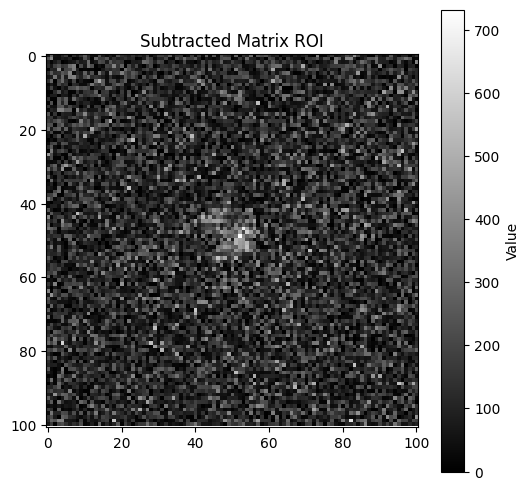

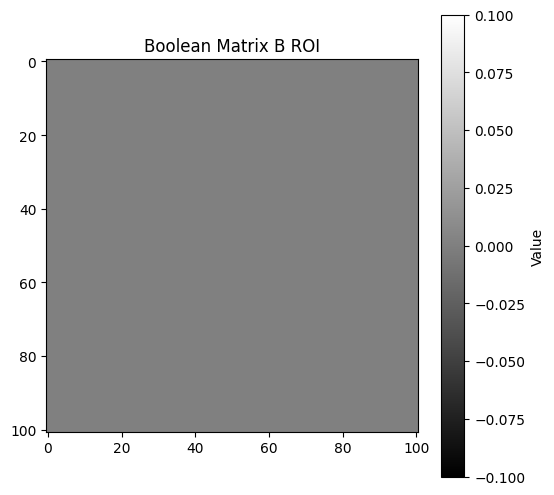

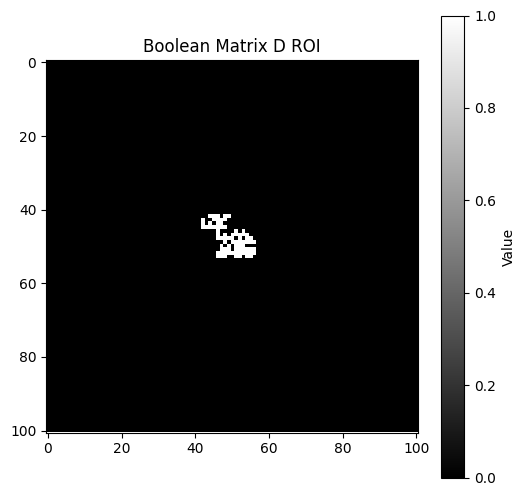

particleCentroidROI[j-1, :]: [0. 0.]


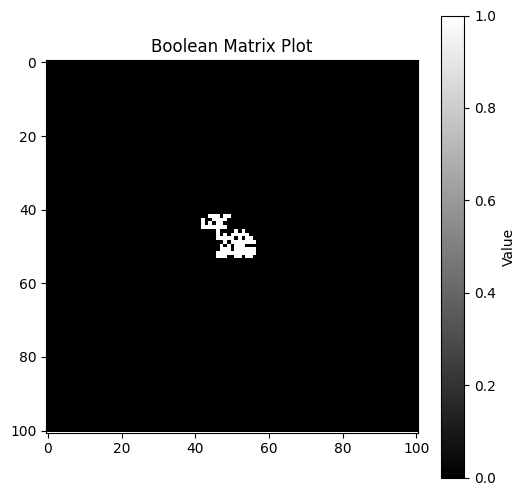

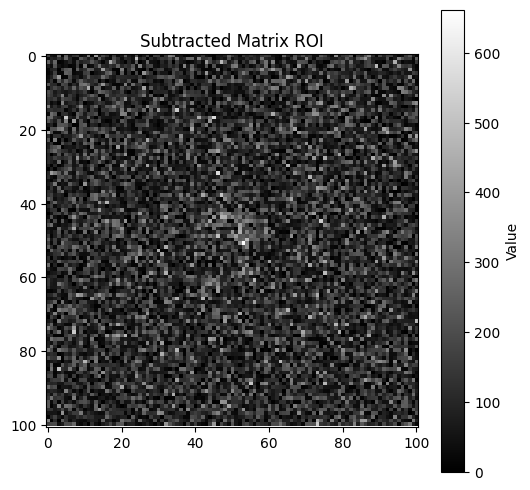

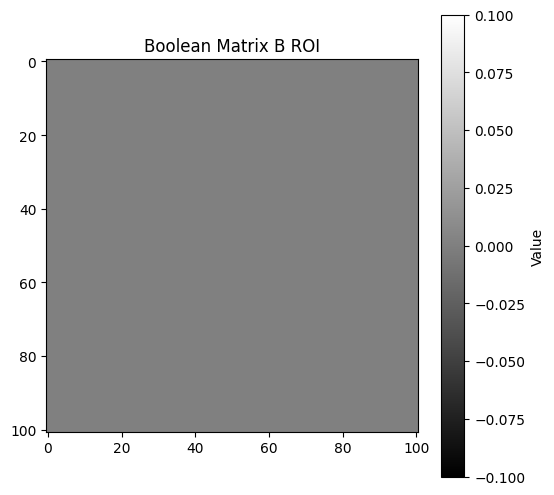

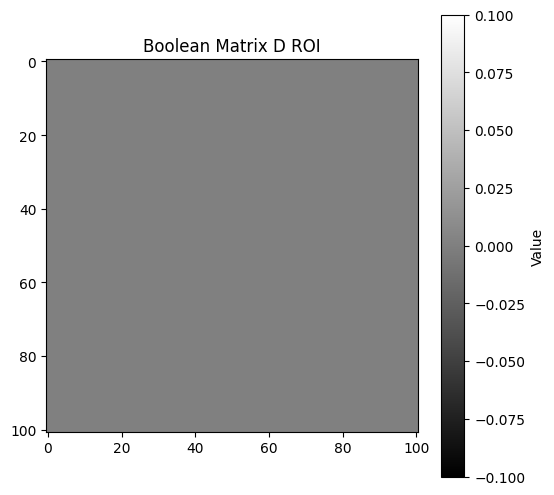

particleCentroidROI[j-1, :]: [48.24050633 49.48101266]


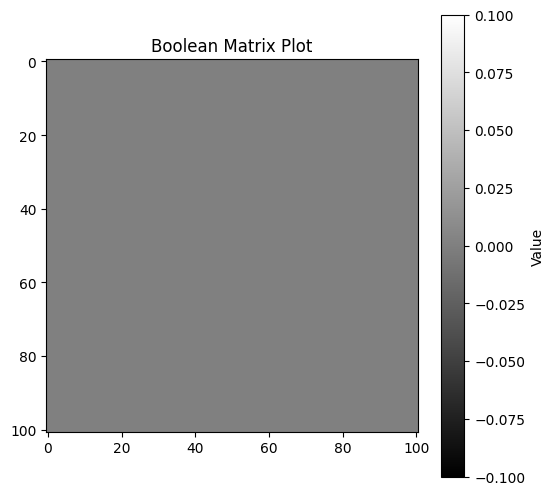

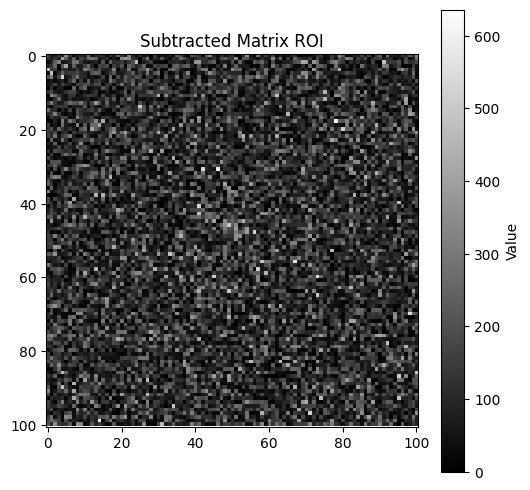

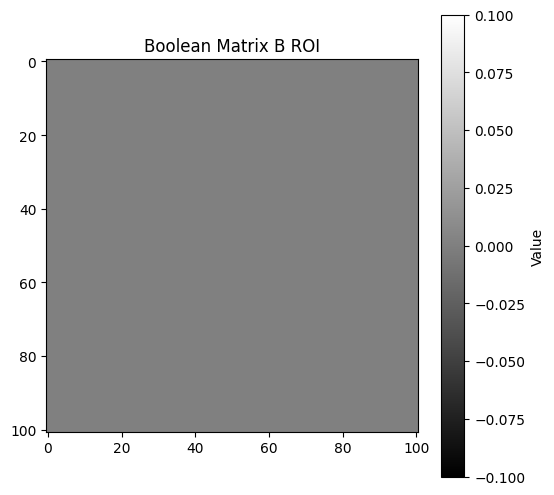

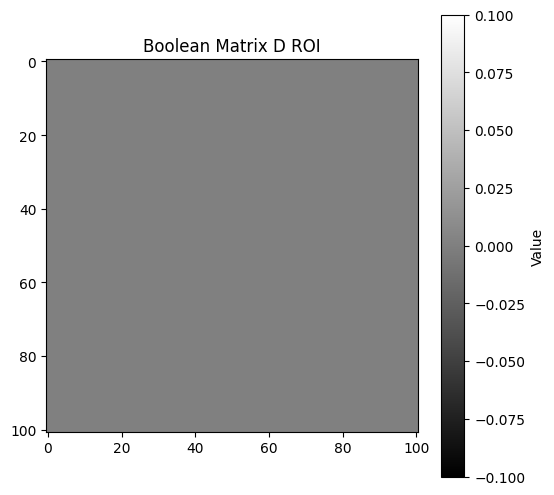

particleCentroidROI[j-1, :]: [51. 51.]


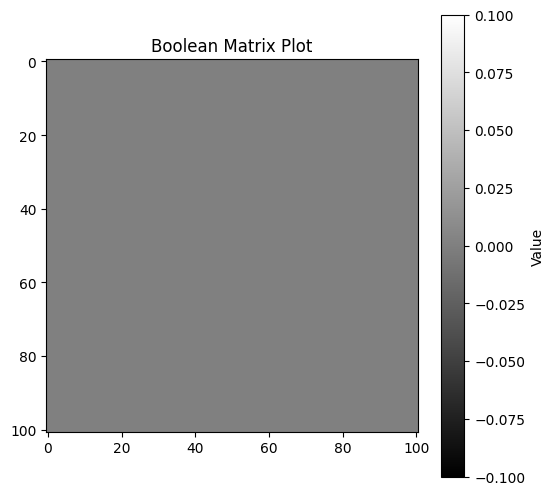

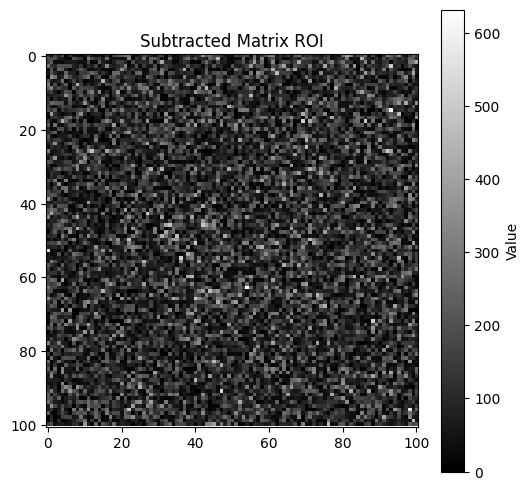

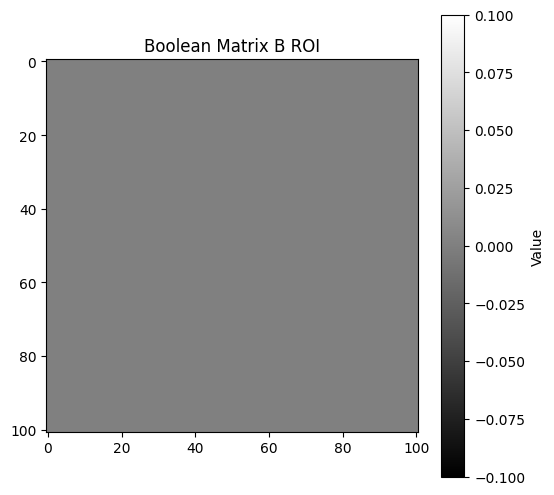

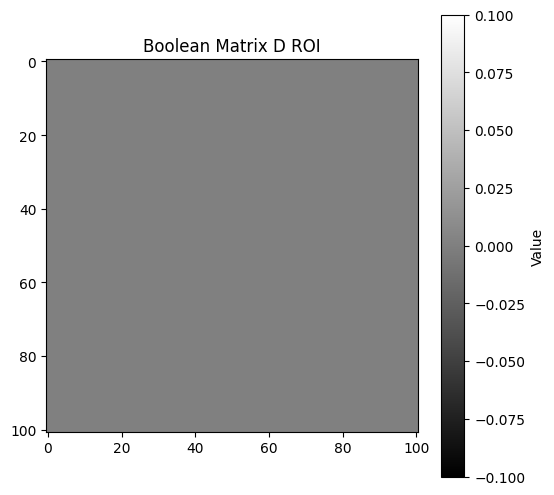

particleCentroidROI[j-1, :]: [51. 51.]


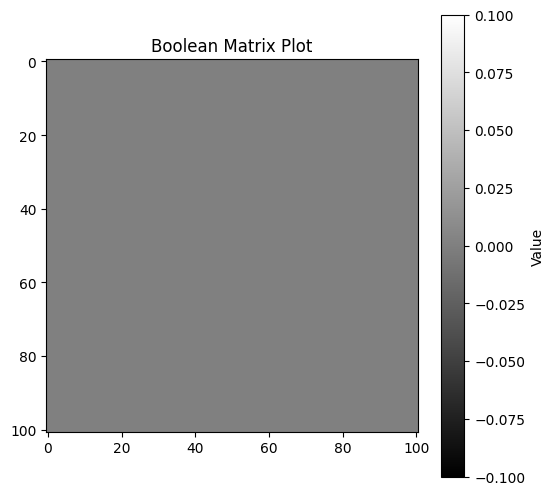

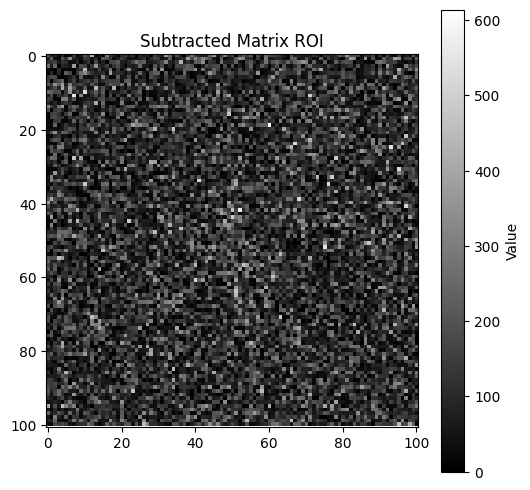

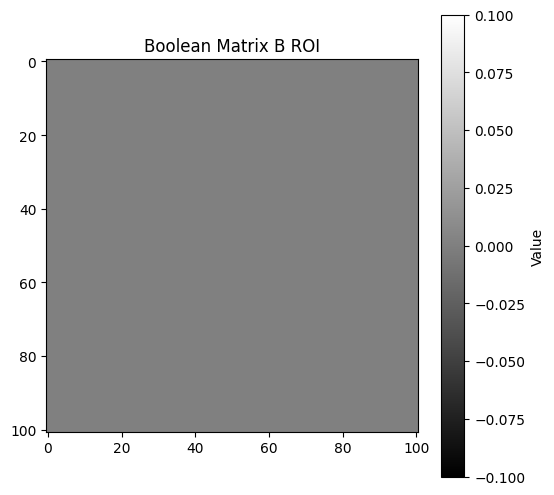

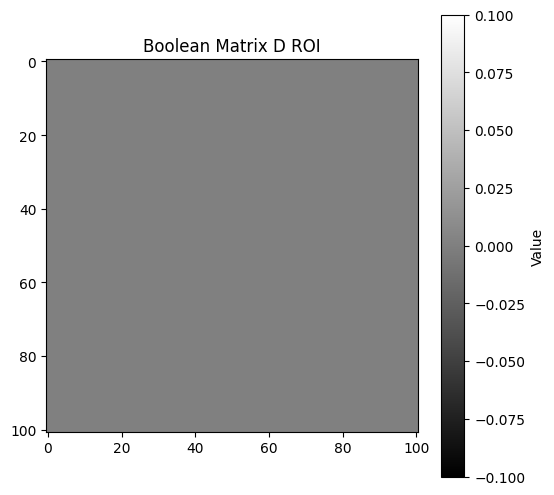

particleCentroidROI[j-1, :]: [51. 51.]


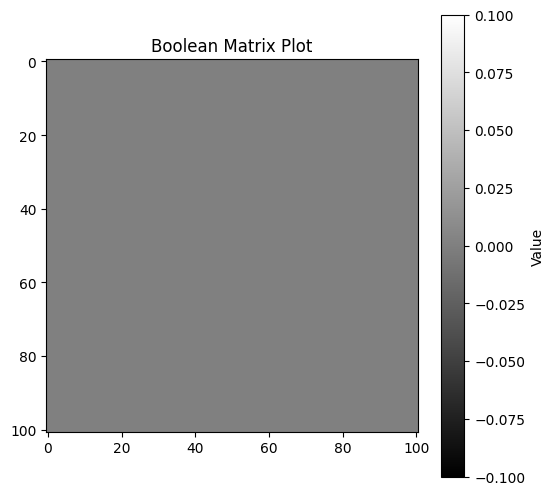

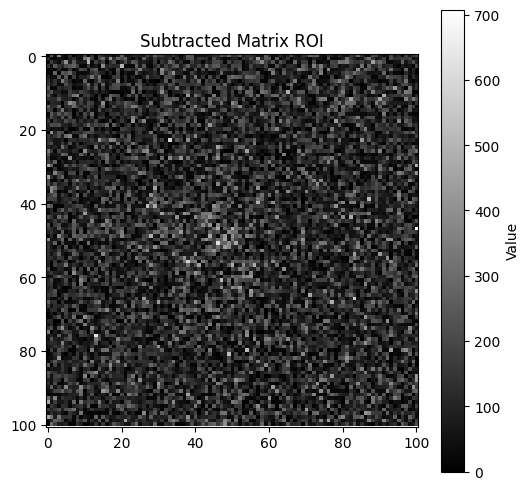

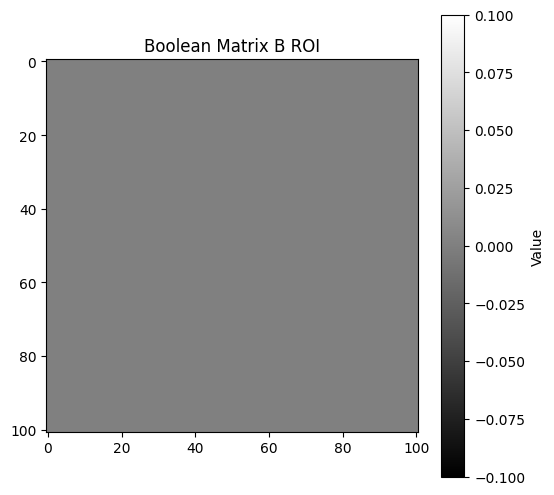

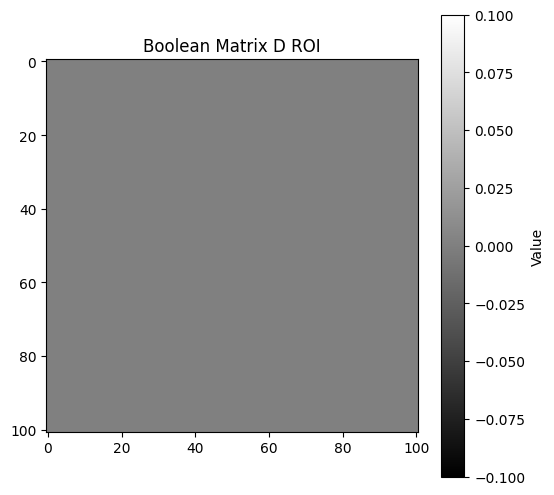

particleCentroidROI[j-1, :]: [51. 51.]


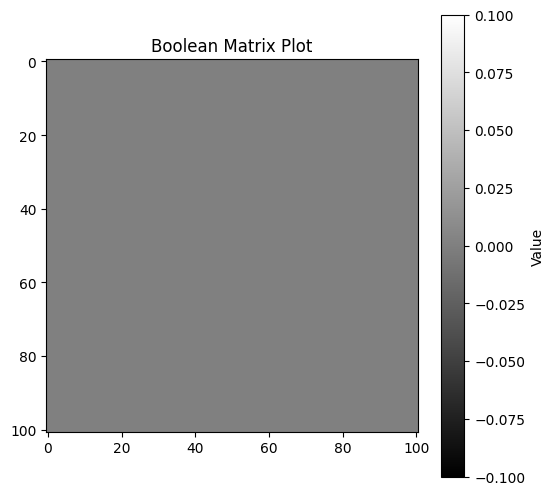

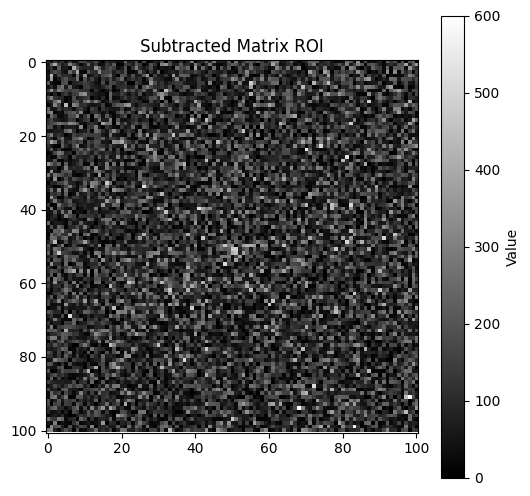

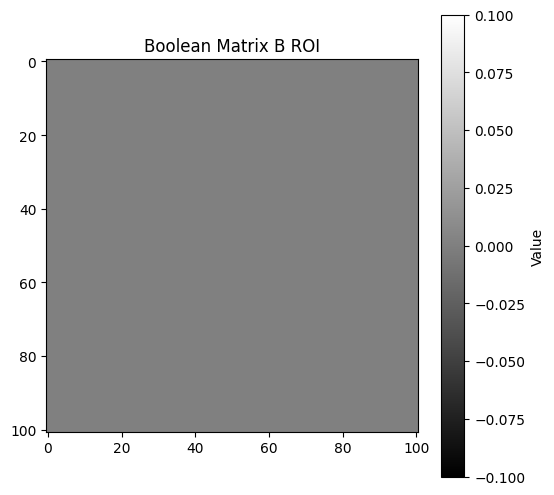

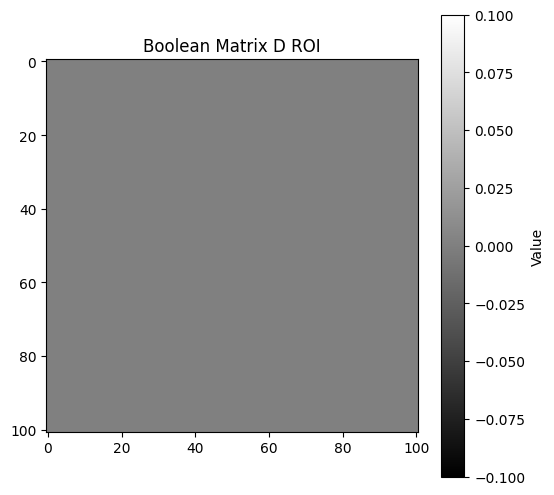

particleCentroidROI[j-1, :]: [51. 51.]


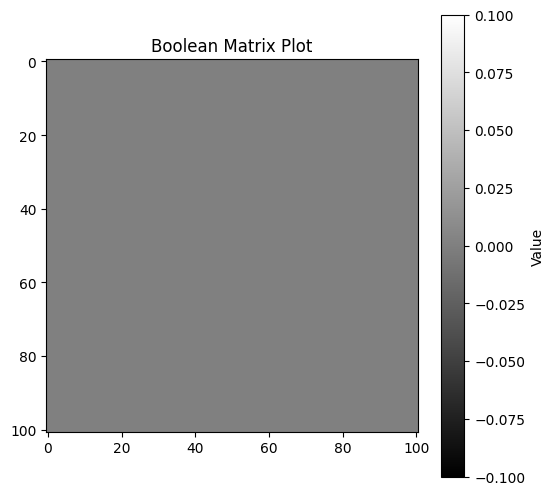

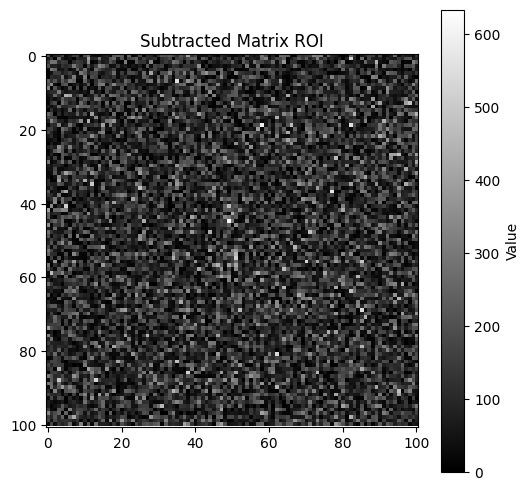

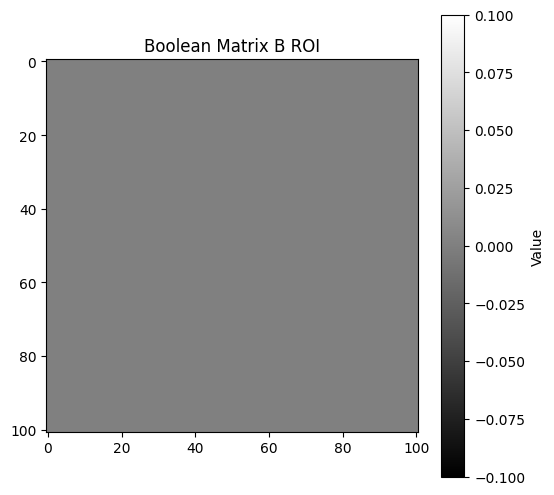

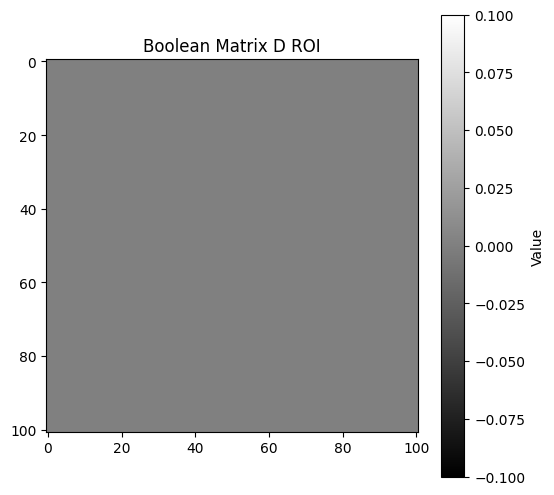

particleCentroidROI[j-1, :]: [51. 51.]


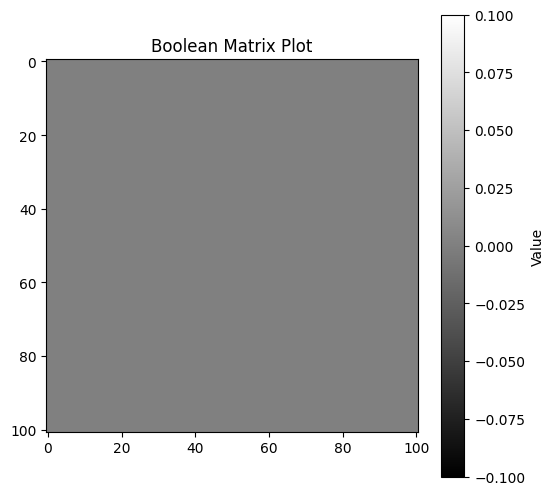

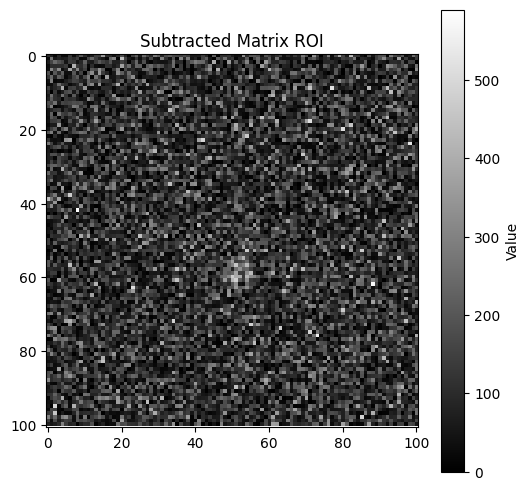

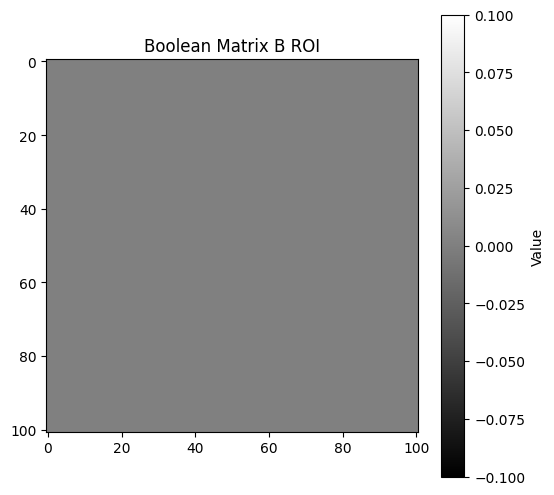

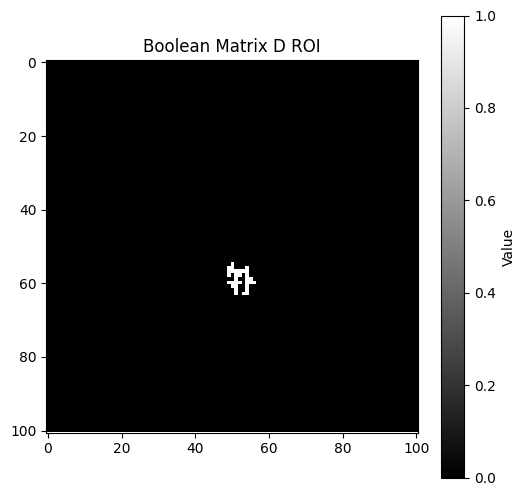

particleCentroidROI[j-1, :]: [51. 51.]


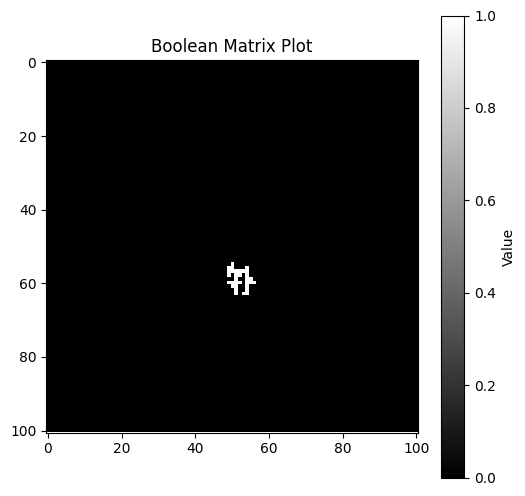

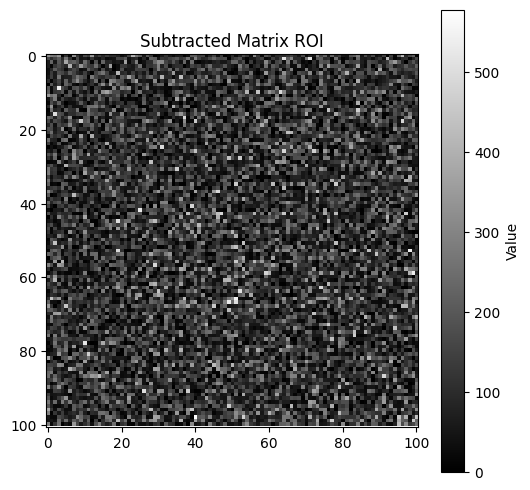

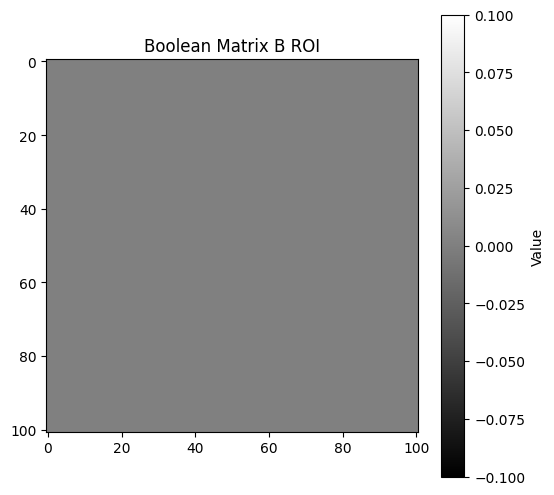

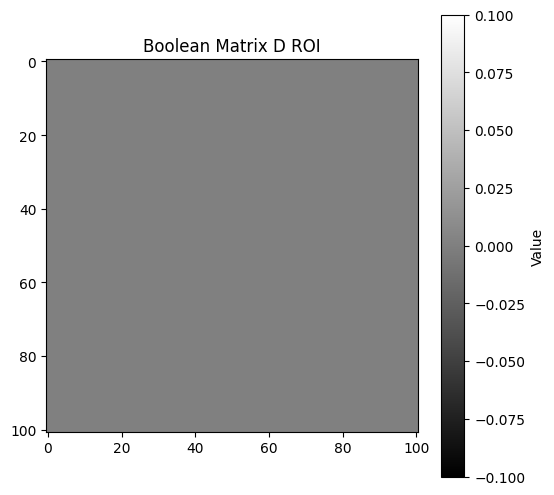

particleCentroidROI[j-1, :]: [59.0625  51.96875]


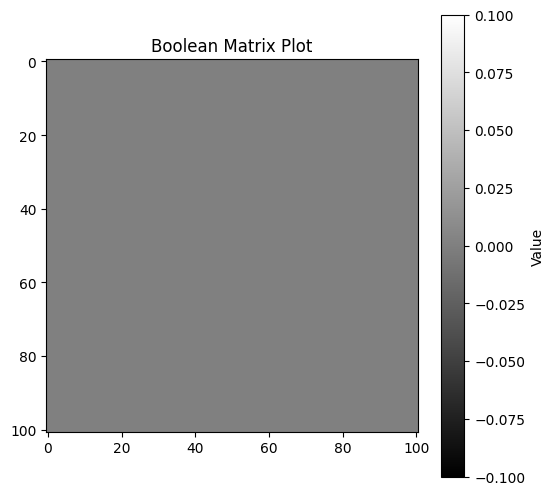

In [85]:
for j in range(stackFrames):
    # determine none-bkg pixels from uint16 matrix (all positive int. of
    # NP) under the assumption that most pixels are bkg
    averageUint=np.mean(np.mean(subtractedMatrix[j,:,:])) #average of the full frame subtracted matrix (uint16)
    stdevUint=np.std(np.std(subtractedMatrix[j,:,:].astype(np.float64)))

    # Create logical mask by filtering by intensity and size

    particleRegionD[j,:,:] = subtractedMatrixD[j, :, :] > (averageUint + (threshStack * stdevUint))
    particleRegionD[j,:,:] = remove_small_objects(particleRegionD[j,:,:], min_size=particleSizeThresh)

    particleRegionB[j,:,:] = subtractedMatrixB[j, :, :] > (averageUint + (threshStack * stdevUint))
    particleRegionB[j,:,:] = remove_small_objects(particleRegionB[j,:,:], min_size=particleSizeThresh)

    particleRegion[j, :, :] = particleRegionD[j,:,:]+particleRegionB[j,:,:]

    # extract particle region within the ROI
    particleRegionROI[j, :, :] = particleRegion[j, startRowY-ROI:startRowY+ROI+1, startColX-ROI:startColX+ROI+1]
    # label regions in the logical mask
    L, num_features = label(particleRegionROI[j, :, :])
    # get properties of the possible particles regions (the centroid and bounding box)
    slices = find_objects(L)
    # calculate centroids and bounding boxes
    centroids = [center_of_mass(particleRegionROI[j, :, :], L, i + 1) for i in range(num_features)]
    bounding_boxes = [sli for sli in slices]
    # combine centroids and bounding boxes into particleProps
    particleProps = [{'Centroid': centroids[i], 'BoundingBox': bounding_boxes[i]} for i in range(num_features)]

    if j>1:
      previousCoord = particleCentroidROI[j-1, :]
    if j<10: # plots logical mask for checking code
      plt.figure(figsize=(6, 6))
      plt.imshow(subtractedMatrix[j, startRowY-ROI:startRowY+ROI+1, startColX-ROI:startColX+ROI+1], cmap='gray')
      plt.colorbar(label='Value')
      plt.title('Subtracted Matrix ROI')
      plt.show()

      plt.figure(figsize=(6, 6))
      plt.imshow(particleRegionB[j, startRowY-ROI:startRowY+ROI+1, startColX-ROI:startColX+ROI+1], cmap='gray')
      plt.colorbar(label='Value')
      plt.title('Boolean Matrix B ROI')
      plt.show()

      plt.figure(figsize=(6, 6))
      plt.imshow(particleRegionD[j, startRowY-ROI:startRowY+ROI+1, startColX-ROI:startColX+ROI+1], cmap='gray')
      plt.colorbar(label='Value')
      plt.title('Boolean Matrix D ROI')
      plt.show()

      print(f"particleCentroidROI[j-1, :]: {particleCentroidROI[j-1, :]}")
      plt.figure(figsize=(6, 6))
      plt.imshow(particleRegionROI[j, :, :], cmap='gray')
      plt.colorbar(label='Value')
      plt.title('Boolean Matrix Plot')
      plt.show()

    # if more than one region identified, choose the one closest to
    # previous centroid (for confined and regular diffusion). For active
    # transport, this can be a problem
    if len(particleProps) >= 2:
      coordList = np.zeros((len(particleProps), 2))
      distances = np.zeros(len(particleProps))
      for h in range(len(particleProps)):
        # get the centroid coordinates
        coordList[h, :] = particleProps[h]['Centroid']
        # compute the distance between previousCoord and the current centroid
        distances[h] = pdist([previousCoord, coordList[h, :]], 'euclidean')[0]
        # update chosenParticle with the index of the minimum distance
        chosenParticle = np.argmin(distances[:h+1]) # try removing +1
      particleProps = [particleProps[chosenParticle]]
      particleRegionROI[j, :, :] = (L == (chosenParticle + 1))  # +1 because Python's label function starts from 1

    if len(particleProps) == 1:
      centroid = particleProps[0]['Centroid']
      particleCentroidROI[j, :] = centroid
      # if the particle jumped too far, set the centroid as last frame
      # location and define a 'default particle mask' centered around the
      # centroid.
      distanceFromPrev = pdist(np.array([previousCoord, particleCentroidROI[j, :]]))[0]
      if distanceFromPrev > jumpThresh:
        JumpFrames += 1
        particleCentroidROI[j, :] = previousCoord  # assume particle didn't move from last frame

        # create a meshgrid for the ROI
        rr, cc = np.meshgrid(np.arange(1, 2*ROI+2), np.arange(1, 2*ROI+2))  # Adjust for Python's 0-indexing

        # update particleRegionROI to include the current mask
        particleRegionROI[j, :, :] = ((rr - particleCentroidROI[j, 0])**2 + (cc - particleCentroidROI[j, 1])**2) < (particleDefaultDiameter / 2)**2

    if len(particleProps) == 0:
      JumpFrames += 1
      particleCentroidROI[j, :] = previousCoord  # assume particle didn't move from last frame
      rr, cc = np.meshgrid(np.arange(1, 2*ROI + 2), np.arange(1, 2*ROI + 2))
      particleRegionROI[j, :, :] = ((rr - particleCentroidROI[j, 0])**2 + (cc - particleCentroidROI[j, 1])**2) < (particleDefaultDiameter / 2)**2

    particlePropsFinal = regionprops(particleRegionROI[j, :, :].astype(int))
    if particlePropsFinal and particlePropsFinal[0].area < minArea:
      # create a meshgrid for the ROI
      rr, cc = np.meshgrid(np.arange(1, 2*ROI+2), np.arange(1, 2*ROI+2))

      # Update particleRegionROI to include the current mask
      particleRegionROI[j, :, :] = ((rr - particleCentroidROI[j, 0])**2 + (cc - particleCentroidROI[j, 1])**2) < (particleDefaultDiameter / 2)**2


In [86]:
centroidGlobalColX = np.round(particleCentroidROI[:, 1]) + (startColX - (ROI + 1))
centroidGlobalRowY = np.round(particleCentroidROI[:, 0]) + (startRowY - (ROI + 1))

T = pd.DataFrame({
      'centroidGlobalColX': centroidGlobalColX,
      'centroidGlobalRowY': centroidGlobalRowY
  })

# print the DataFrame to verify
print(T)

     centroidGlobalColX  centroidGlobalRowY
0                 683.0               657.0
1                 685.0               660.0
2                 685.0               660.0
3                 685.0               660.0
4                 685.0               660.0
..                  ...                 ...
296               695.0               674.0
297               695.0               674.0
298               695.0               674.0
299               695.0               674.0
300               695.0               674.0

[301 rows x 2 columns]


In [87]:
# save the DataFrame to an xlsx file

coords_dir = os.path.join(f'{savingPath}coords')
os.makedirs(coords_dir, exist_ok=True) # Create the directory if it doesn't exist

T.to_excel(os.path.join(coords_dir, f'{os.path.basename(saveBaseName)}_Coords.xlsx'), index=False) # Save the file in the created directory


In [88]:
rawROI = np.zeros((stackFrames, 2 * ROI + 1, 2 * ROI + 1), dtype=np.uint16)
nonebkgROI = np.zeros((stackFrames, 2 * ROI + 1, 2 * ROI + 1), dtype=bool)
bkgregionROI = np.zeros((stackFrames, 2 * ROI + 1, 2 * ROI + 1), dtype=bool)
localAverage = np.zeros(stackFrames)
localStdev = np.zeros(stackFrames)
particleSignal = np.zeros(stackFrames)
particleSignalBright = np.zeros(stackFrames)
particleSignalDark = np.zeros(stackFrames)
nanCountBrights = np.zeros(stackFrames)
nanCountDarks = np.zeros(stackFrames)
numberBrightPixels = np.zeros(stackFrames)
numberDarkPixels = np.zeros(stackFrames)

In [89]:
for j in range(stackFrames):
    rawROI[j, :, :] = stack[j, startRowY - ROI:startRowY + ROI + 1, startColX - ROI:startColX + ROI + 1]
    rawROIHolder = rawROI[j, :, :]
    averageROI = np.mean(rawROIHolder)
    NPidentifyROI = filters.median(rawROIHolder - averageROI) + filters.median(averageROI - rawROIHolder)
    averageFrame = np.mean(NPidentifyROI)
    stdevFrame = np.std(NPidentifyROI)
    nonebkgROI[j, ...] = morphology.remove_small_objects(NPidentifyROI > (averageFrame + threshFrame * stdevFrame), particleSizeThresh)
    bkgregionROI[j, ...] = ~nonebkgROI[j, ...] & ~particleRegionROI[j, ...]

    particleCentroidROIround = np.round(particleCentroidROI[j, :]).astype(int)

    if (particleCentroidROIround[0] - ROISmall < 0 or particleCentroidROIround[1] - ROISmall < 0 or
            particleCentroidROIround[0] + ROISmall >= 2 * ROI + 1 or particleCentroidROIround[1] + ROISmall >= 2 * ROI + 1):
        print('Index Error')
        continue

    rawROIholderLocal = rawROI[
        j,
        particleCentroidROIround[1] - ROISmall:particleCentroidROIround[1] + ROISmall + 1,
        particleCentroidROIround[0] - ROISmall:particleCentroidROIround[0] + ROISmall + 1
    ]
    notParticlesLocal = bkgregionROI[
        j,
        particleCentroidROIround[1] - ROISmall:particleCentroidROIround[1] + ROISmall + 1,
        particleCentroidROIround[0] - ROISmall:particleCentroidROIround[0] + ROISmall + 1
    ]

    if np.any(notParticlesLocal):  # check if there are any true elements
      localAverage[j] = np.mean(rawROIholderLocal[notParticlesLocal])
      localStdev[j] = np.std(rawROIholderLocal[notParticlesLocal])
    else:
      localAverage[j] = 0
      localStdev[j] = 0

    particleSignal[j] = np.mean(rawROIHolder[particleRegionROI[j, ...]])

    particleSignalList = rawROIHolder[particleRegionROI[j, ...]]
    particleSignalListBright = particleSignalList > localAverage[j]
    particleSignalListDark = particleSignalList < localAverage[j]
    numberBrightPixels[j] = np.sum(particleSignalListBright)
    numberDarkPixels[j] = np.sum(particleSignalListDark)

    if np.any(particleSignalListBright):  # check if there are any true elements
        particleSignalBright[j] = np.mean(particleSignalList[particleSignalListBright])
    else:
        particleSignalBright[j] = localAverage[j]
        nanCountBrights[j] = 1

    if np.any(particleSignalListDark):  # check if there are any true elements
        particleSignalDark[j] = np.mean(particleSignalList[particleSignalListDark])
    else:
        particleSignalDark[j] = localAverage[j]
        nanCountDarks[j] = 1

In [90]:
brightContrast = (particleSignalBright - localAverage) / localAverage
darkContrast = (particleSignalDark - localAverage) / localAverage
brightContrastNorm = (brightContrast - np.min(brightContrast)) / (np.max(brightContrast) - np.min(brightContrast))
darkContrastNorm = (darkContrast - np.max(darkContrast)) / (np.min(darkContrast) - np.max(darkContrast))
contrastDifference = brightContrastNorm - darkContrastNorm
contrast = (particleSignal - localAverage) / localAverage

particleCentroidROIColXSmooth = gaussian_filter(particleCentroidROI[:, 1], sigma=2)
particleCentroidROIRowYSmooth = gaussian_filter(particleCentroidROI[:, 0], sigma=2)
centroidGlobalColXSmooth = gaussian_filter(centroidGlobalColX, sigma=2)
centroidGlobalRowYSmooth = gaussian_filter(centroidGlobalRowY, sigma=2)

positionColX_um = centroidGlobalColX * pixelSize
positionRowY_um = centroidGlobalRowY * pixelSize
positionColXFirst = positionColX_um[0]
positionRowYFirst = positionRowY_um[0]
displacement_um = np.sqrt((positionColX_um - positionColXFirst) ** 2 + (positionRowY_um - positionRowYFirst) ** 2)
displacement_umSmooth = gaussian_filter(displacement_um, sigma=2)

In [91]:
# saving results
frameNum = np.arange(1, stackFrames + 1)
timeStampExp = np.arange(0, stackFrames * exposureTime, exposureTime)

result_df = pd.DataFrame({
  'frameNum': frameNum, 'timeStampExp': timeStampExp, 'localAverage': localAverage,
  'localStdev': localStdev, 'particleSignal': particleSignal, 'contrast': contrast,
  'particleSignalBright': particleSignalBright, 'particleSignalDark': particleSignalDark,
  'brightContrast': brightContrast, 'darkContrast': darkContrast, 'brightContrastNorm': brightContrastNorm,
  'darkContrastNorm': darkContrastNorm, 'contrastDifference': contrastDifference,
  'particleCentroidROIX': particleCentroidROI[:, 1], 'particleCentroidROIY': particleCentroidROI[:, 0],
  'particleCentroidROIColXSmooth': particleCentroidROIColXSmooth, 'particleCentroidROIRowYSmooth': particleCentroidROIRowYSmooth,
  'centroidGlobalColX': centroidGlobalColX, 'centroidGlobalRowY': centroidGlobalRowY,
  'centroidGlobalColXSmooth': centroidGlobalColXSmooth, 'centroidGlobalRowYSmooth': centroidGlobalRowYSmooth,
  'displacement_um': displacement_um, 'displacement_umSmooth': displacement_umSmooth
})

In [92]:
i# save the DataFrame to an xlsx file

result_save_path = f'{savingPath}/result/'
os.makedirs(result_save_path, exist_ok=True) # Create the directory if it doesn't exist
result_df.to_excel(f'{result_save_path}/Result.xlsx', index=False)

In [93]:
parameters_df = pd.DataFrame({
  'imageFolder': [stackPath], 'imageFile': [stackFile], 'SFrame': [SFrame], 'EFrame': [EFrame],
  'startColX': [startColX], 'startRowY': [startRowY], 'analyzeMode': [analyzeMode], 'ROI': [ROI],
  'ROISmall': [ROISmall], 'frameRange': [frameRange], 'threshStack': [threshStack], 'threshFrame': [threshFrame],
  'particleSizeThresh': [particleSizeThresh], 'particleDefaultDiameter': [particleDefaultDiameter],
  'minArea': [minArea], 'jumpThresh': [jumpThresh], 'exposureTime': [exposureTime], 'pixelSize': [pixelSize]
})

parameters_save_path = f'{savingPath}/parameters/'
os.makedirs(parameters_save_path, exist_ok=True) # Create the directory if it doesn't exist
parameters_df.to_excel(f'{parameters_save_path}/Parameters.xlsx', index=False)

rawROI_uint16 = rawROI.astype(np.uint16)
io.imsave(f'{saveBaseName}_ROI.tif', rawROI_uint16)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Prof._Lee_Research/Process/Particle P1_C1_S1_11/Cell1_S1_ParticleP1_C1_S1_11_frameRange20_X685_Y660_ROI.tif is a low contrast image
  return func(*args, **kwargs)


In [94]:
particleidentified = np.zeros_like(rawROI_uint16)
for h in range(stackFrames):
  roiframe = rawROI[h, ...]
  particleframe = np.zeros_like(roiframe)
  particleframe[particleRegionROI[h, ...]] = roiframe[particleRegionROI[h, ...]]
  particleframe[~particleRegionROI[h, ...]] = localAverage[h] - 100
  particleidentified[h, ...] = particleframe

In [95]:
  io.imsave(f'{saveBaseNameMovie}_Particle {particleID}.tif', particleidentified)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Prof._Lee_Research/Process/Particle P1_C1_S1_11/Cell1_S1_frameRange20_Particle P1_C1_S1_11.tif is a low contrast image
  return func(*args, **kwargs)


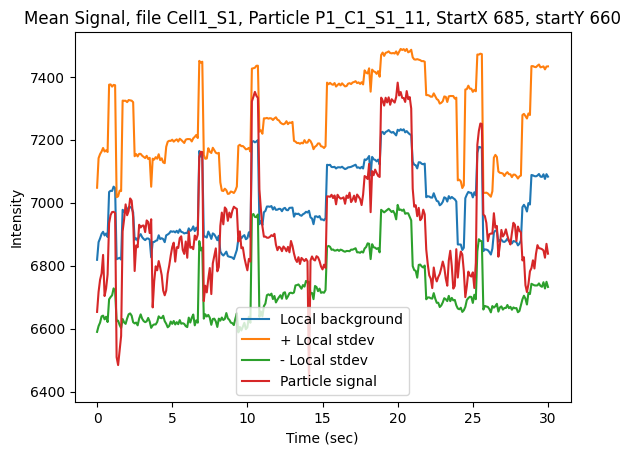

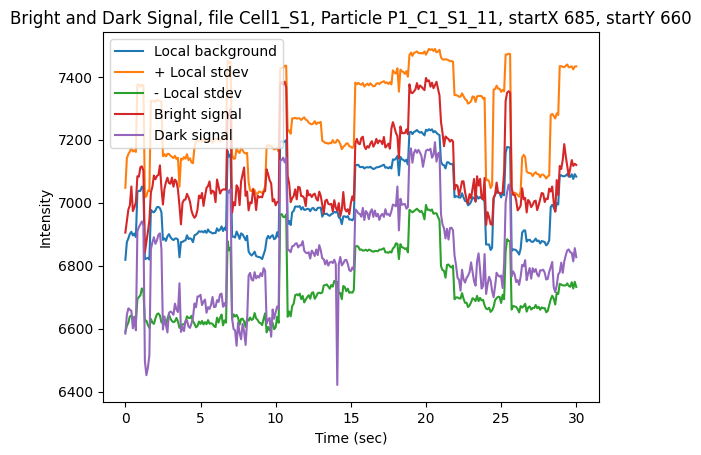

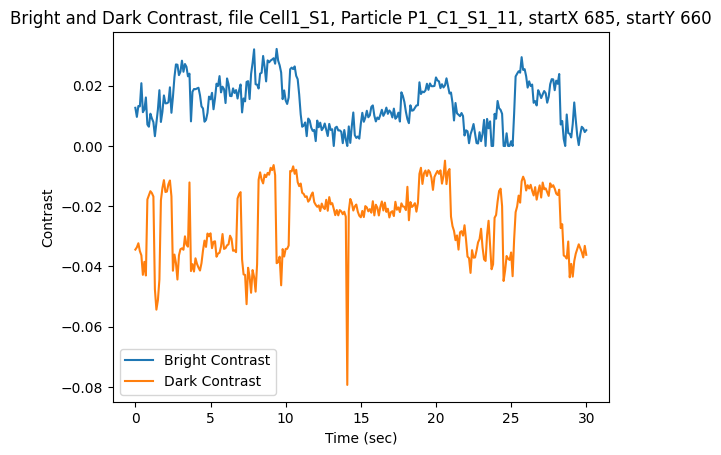

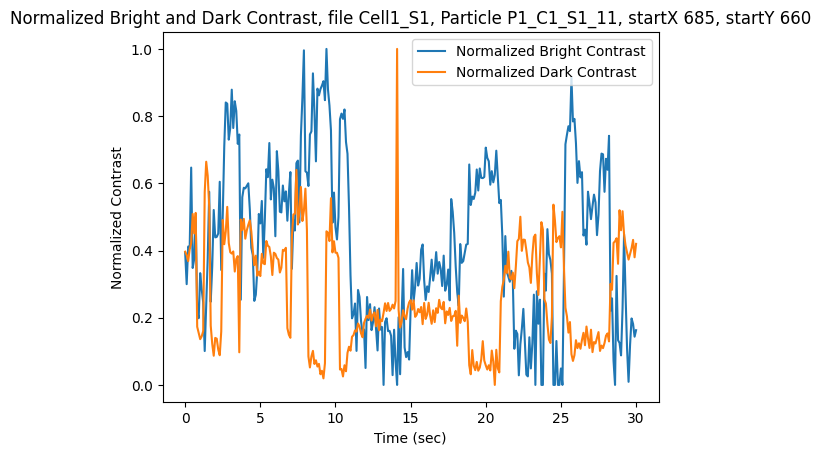

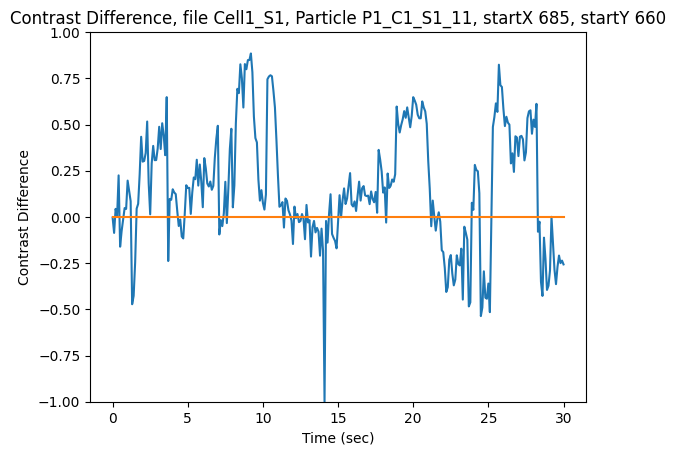

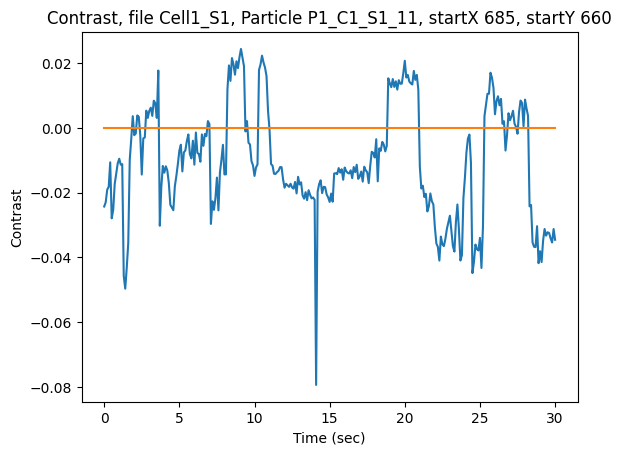

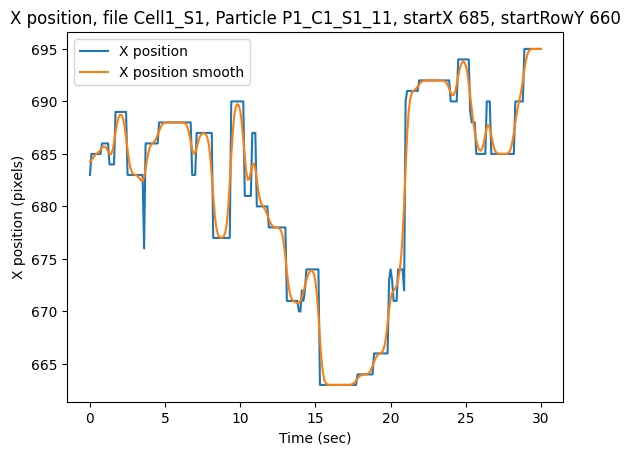

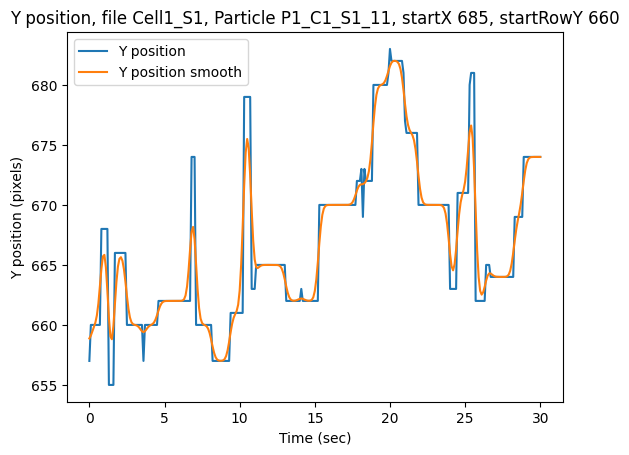

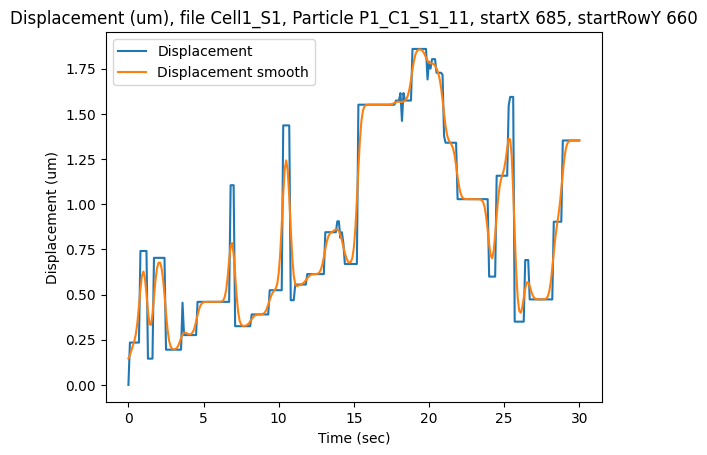

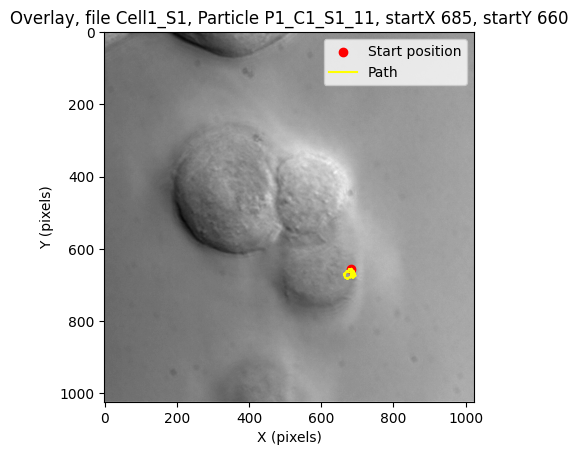

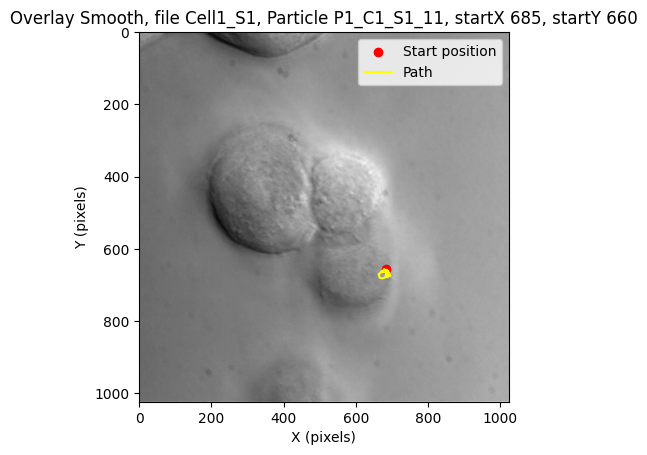

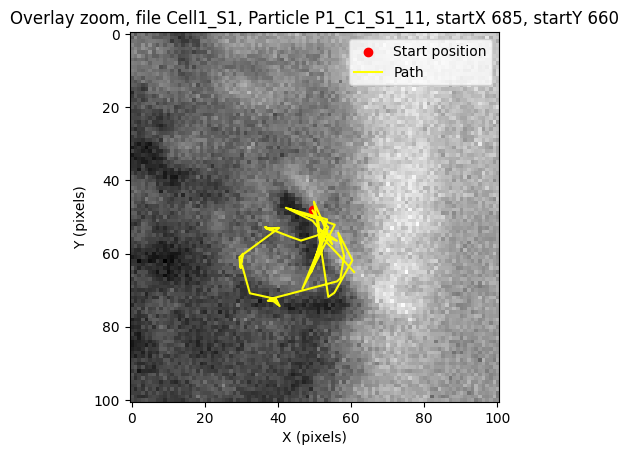

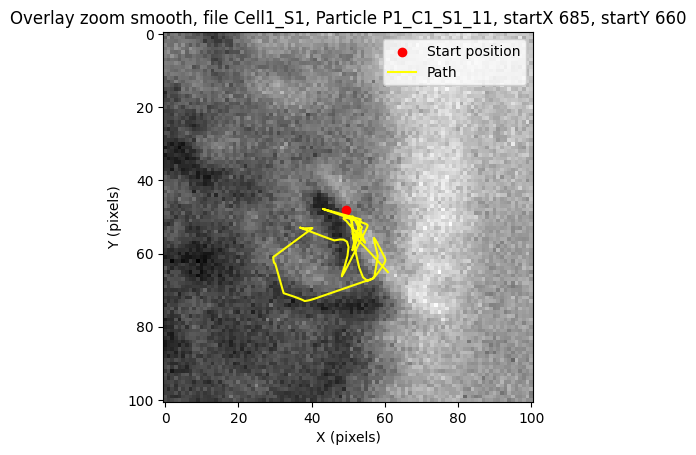

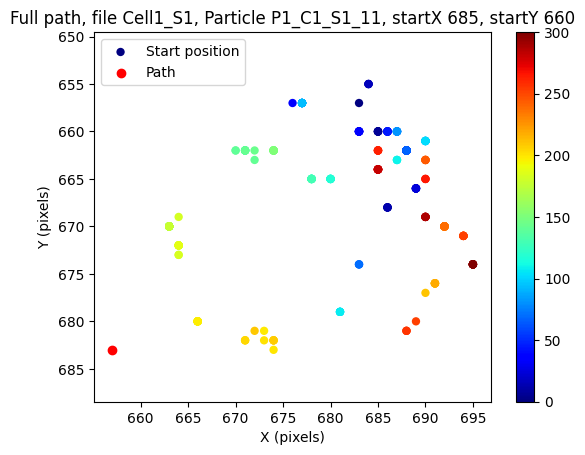

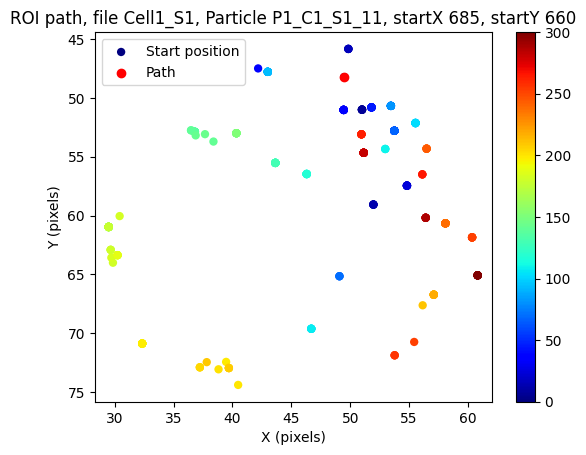

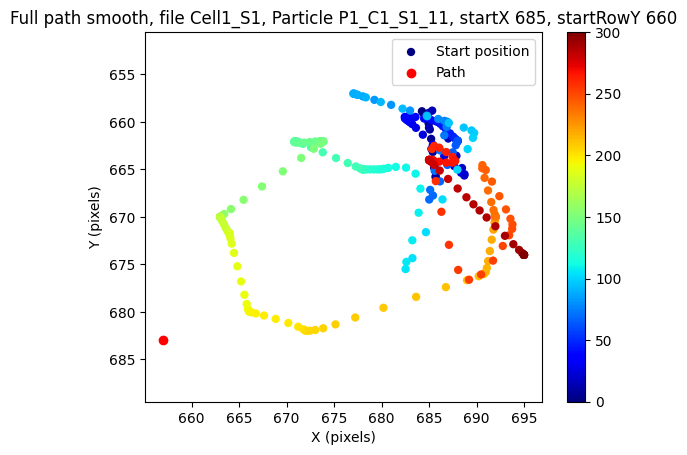

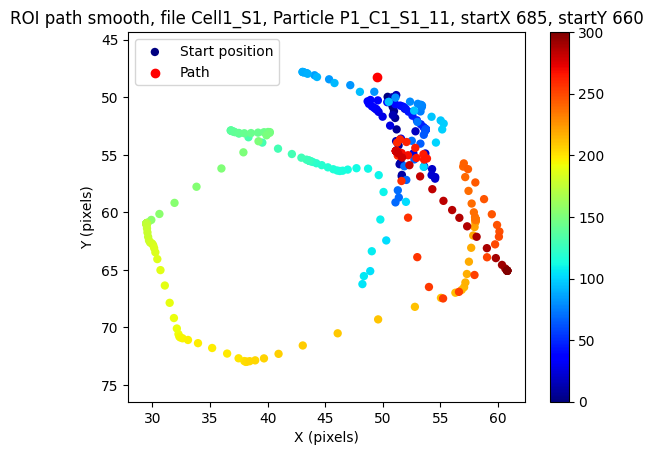

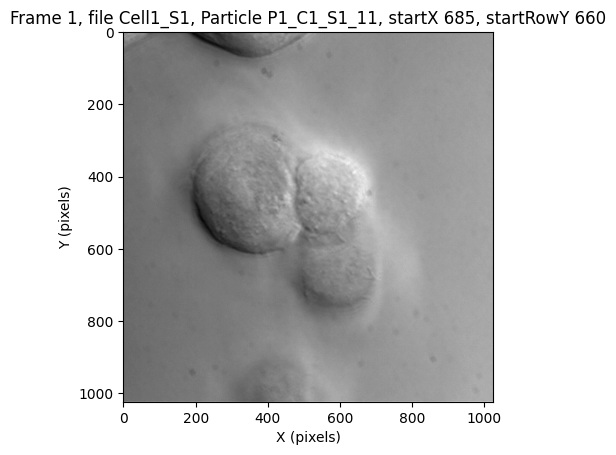

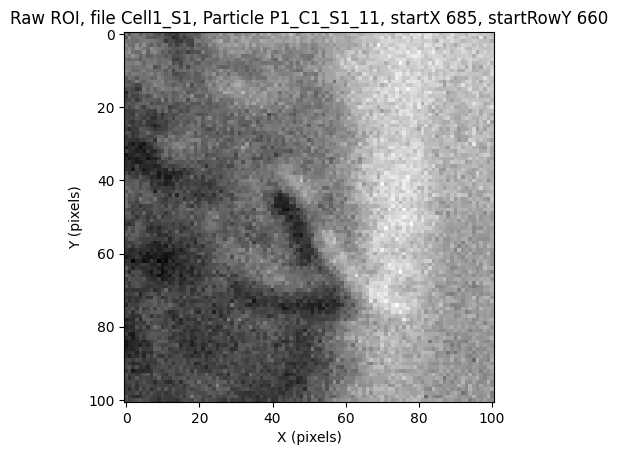

In [96]:
eps_save_path = f'{savingPath}/epsFiles/'
os.makedirs(result_save_path, exist_ok=True) # Create the directory if it doesn't exist

# plots
plt.figure()
plt.plot(timeStampExp, localAverage, label='Local background')
plt.plot(timeStampExp, localAverage + localStdev, label='+ Local stdev')
plt.plot(timeStampExp, localAverage - localStdev, label='- Local stdev')
plt.plot(timeStampExp, particleSignal, label='Particle signal')
plt.title(f'Mean Signal, file {saveID}, Particle {particleID}, StartX {startColX}, startY {startRowY}')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Intensity')
os.makedirs(f'{eps_save_path}', exist_ok=True) # Create the directory if it doesn't exist
plt.savefig(f'{eps_save_path}_SignalMean.eps')
plt.show()

plt.figure()
plt.plot(timeStampExp, localAverage, label='Local background')
plt.plot(timeStampExp, localAverage + localStdev, label='+ Local stdev')
plt.plot(timeStampExp, localAverage - localStdev, label='- Local stdev')
plt.plot(timeStampExp, particleSignalBright, label='Bright signal')
plt.plot(timeStampExp, particleSignalDark, label='Dark signal')
plt.title(f'Bright and Dark Signal, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Intensity')
plt.savefig(f'{eps_save_path}_SignalBrightDark.eps')
plt.show()

plt.figure()
plt.plot(timeStampExp, brightContrast, label='Bright Contrast')
plt.plot(timeStampExp, darkContrast, label='Dark Contrast')
plt.title(f'Bright and Dark Contrast, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Contrast')
plt.savefig(f'{eps_save_path}_BD_Contrast.eps')
plt.show()

plt.figure()
plt.plot(timeStampExp, brightContrastNorm, label='Normalized Bright Contrast')
plt.plot(timeStampExp, darkContrastNorm, label='Normalized Dark Contrast')
plt.title(f'Normalized Bright and Dark Contrast, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Normalized Contrast')
plt.savefig(f'{eps_save_path}_ContrastNorm.eps')
plt.show()

plt.figure()
plt.plot(timeStampExp, contrastDifference)
plt.plot(timeStampExp, np.zeros(stackFrames), label='Zero line')
plt.title(f'Contrast Difference, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('Time (sec)')
plt.ylabel('Contrast Difference')
plt.ylim([-1, 1])
plt.savefig(f'{eps_save_path}_ContrastDiff.eps')
plt.show()

plt.figure()
plt.plot(timeStampExp, contrast)
plt.plot(timeStampExp, np.zeros(stackFrames), label='Zero line')
plt.title(f'Contrast, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('Time (sec)')
plt.ylabel('Contrast')
plt.savefig(f'{eps_save_path}_Contrast.eps')
plt.show()

plt.figure()
plt.plot(timeStampExp, centroidGlobalColX, label='X position')
plt.plot(timeStampExp, centroidGlobalColXSmooth, label='X position smooth')
plt.title(f'X position, file {saveID}, Particle {particleID}, startX {startColX}, startRowY {startRowY}')
plt.xlabel('Time (sec)')
plt.ylabel('X position (pixels)')
plt.legend()
plt.savefig(f'{eps_save_path}_positionX.eps')
plt.show()

plt.figure()
plt.plot(timeStampExp, centroidGlobalRowY, label='Y position')
plt.plot(timeStampExp, centroidGlobalRowYSmooth, label='Y position smooth')
plt.title(f'Y position, file {saveID}, Particle {particleID}, startX {startColX}, startRowY {startRowY}')
plt.xlabel('Time (sec)')
plt.ylabel('Y position (pixels)')
plt.legend()
plt.savefig(f'{eps_save_path}_positionY.eps')
plt.show()

plt.figure()
plt.plot(timeStampExp, displacement_um, label='Displacement')
plt.plot(timeStampExp, displacement_umSmooth, label='Displacement smooth')
plt.title(f'Displacement (um), file {saveID}, Particle {particleID}, startX {startColX}, startRowY {startRowY}')
plt.xlabel('Time (sec)')
plt.ylabel('Displacement (um)')
plt.legend()
plt.savefig(f'{eps_save_path}_Displacement.eps')
plt.show()

plt.figure()
plt.imshow(stack[0], cmap='gray')
plt.scatter(centroidGlobalColX[0], centroidGlobalRowY[0], color='red')
plt.plot(centroidGlobalColX, centroidGlobalRowY, color='yellow')
plt.title(f'Overlay, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend(['Start position', 'Path'])
plt.savefig(f'{eps_save_path}_Overlay.eps')
plt.show()

plt.figure()
plt.imshow(stack[0], cmap='gray')
plt.scatter(centroidGlobalColX[0], centroidGlobalRowY[0], color='red')
plt.plot(centroidGlobalColXSmooth, centroidGlobalRowYSmooth, color='yellow')
plt.title(f'Overlay Smooth, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend(['Start position', 'Path'])
plt.savefig(f'{eps_save_path}_OverlaySmooth.eps')
plt.show()

plt.figure()
plt.imshow(rawROI[0, :, :], cmap='gray')
plt.scatter(particleCentroidROI[0, 1], particleCentroidROI[0, 0], color='red')
plt.plot(particleCentroidROI[:, 1], particleCentroidROI[:, 0], color='yellow')
plt.title(f'Overlay zoom, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend(['Start position', 'Path'])
plt.savefig(f'{eps_save_path}_OverlayZoom.eps')
plt.show()

plt.figure()
plt.imshow(rawROI[0, :, :], cmap='gray')
plt.scatter(particleCentroidROI[0, 1], particleCentroidROI[0, 0], color='red')
plt.plot(particleCentroidROIColXSmooth, particleCentroidROIRowYSmooth, color='yellow')
plt.title(f'Overlay zoom smooth, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend(['Start position', 'Path'])
plt.savefig(f'{eps_save_path}_OverlayZoomSmooth.eps')
plt.show()

plt.figure()
c = np.arange(len(centroidGlobalColX))
plt.scatter(centroidGlobalColX, centroidGlobalRowY, c=c, cmap='jet', edgecolor='none')
plt.colorbar()
plt.scatter(centroidGlobalRowY[0], centroidGlobalColX[0], color='red')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title(f'Full path, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend(['Start position', 'Path'])
plt.savefig(f'{eps_save_path}_PathFull.eps')
plt.show()

plt.figure()
c = np.arange(len(particleCentroidROI))
plt.scatter(particleCentroidROI[:, 1], particleCentroidROI[:, 0], c=c, cmap='jet', edgecolor='none')
plt.colorbar()
plt.scatter(particleCentroidROI[0, 1], particleCentroidROI[0, 0], color='red')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title(f'ROI path, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend(['Start position', 'Path'])
plt.savefig(f'{eps_save_path}_PathROI.eps')
plt.show()

plt.figure()
c = np.arange(len(centroidGlobalColXSmooth))
plt.scatter(centroidGlobalColXSmooth, centroidGlobalRowYSmooth, c=c, cmap='jet', edgecolor='none')
plt.colorbar()
plt.scatter(centroidGlobalRowY[0], centroidGlobalColX[0], color='red')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title(f'Full path smooth, file {saveID}, Particle {particleID}, startX {startColX}, startRowY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend(['Start position', 'Path'])
plt.savefig(f'{eps_save_path}_PathFullSmooth.eps')
plt.show()

plt.figure()
c = np.arange(len(particleCentroidROIColXSmooth))
plt.scatter(particleCentroidROIColXSmooth, particleCentroidROIRowYSmooth, c=c, cmap='jet', edgecolor='none')
plt.colorbar()
plt.scatter(particleCentroidROI[0, 1], particleCentroidROI[0, 0], color='red')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title(f'ROI path smooth, file {saveID}, Particle {particleID}, startX {startColX}, startY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend(['Start position', 'Path'])
plt.savefig(f'{eps_save_path}_PathROISmooth.eps')
plt.show()

plt.figure()
plt.imshow(stack[0], cmap='gray')
plt.title(f'Frame {SFrame}, file {saveID}, Particle {particleID}, startX {startColX}, startRowY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.savefig(f'{eps_save_path}_Frame{SFrame}.eps')
plt.show()

plt.figure()
plt.imshow(rawROI[0, :, :], cmap='gray')
plt.title(f'Raw ROI, file {saveID}, Particle {particleID}, startX {startColX}, startRowY {startRowY}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.savefig(f'{eps_save_path}_Frame1RawROI.eps')
plt.show()

plt.close('all')